In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sts

import matplotlib.pyplot as plt

from scipy.stats import shapiro
from statsmodels.stats.multitest import multipletests

pd.set_option('display.max_columns', None)

### Useful functions

In [2]:
def filter_by_features(contacts_df,
                       energy_type,
                       mutation_type,
                       chain_type='both',
                       clean_missing_energy=True):
    """
    Filters the contacts table by specified features

    Parameters
    ----------
    contacts_df : DataFrame
        Contacts table
    energy_type : str
        
    mutation_type : str
        "Mutated" or "Mutated_repacked"
    contacting_parts : str
        _description_
    chain_type : str, optional
        _description_, by default 'both'
    clean_missing_energy : bool, optional
        If True, deletes contacts with missing energy, by default True

    Returns
    -------
    filtered_df : DataFrame
        Filtered contacts
    """
    filtered_df = contacts_df.copy()
    filtered_df = filtered_df[filtered_df['energy.type'] == energy_type].drop('energy.type', 1)
    if 'mutation.type' in filtered_df.columns:
        filtered_df = filtered_df[filtered_df['mutation.type'] == mutation_type].drop('mutation.type', 1)
    else:
        warnings.warn('Mutation type is not reported in dataset')
    if clean_missing_energy: 
        filtered_df = filtered_df[filtered_df['byres.energy'] != 'none']
        filtered_df.loc[:,'byres.energy'] = filtered_df['byres.energy'].astype(np.float64)
    
    if chain_type != 'both':
        filtered_df = filtered_df[filtered_df['chain.type'] == chain_type]
        
    # Для глицинов брать ВСЁ
    filtered_df = filtered_df[
        (filtered_df['rin.contact.part'] == 'SC_SC') |    # both side chains or
        (filtered_df['resname.tcr'] == 'G') |             # cdr3 glycine main chain or
        (filtered_df['resname.peptide'] == 'G')           # peptide glycine main chain
    ]
        
    filtered_df.reset_index(inplace=True)
    filtered_df.rename(columns={'index': '_index'}, inplace=True)

    return filtered_df

In [3]:
def weights_by_enegy(energy):
    ENERGY_THRESHOLD = -3 
    
    T = 273    # K
    kT = 1.987 * 10**-3 * T    # kcal / mol
    energy = energy.values
    energy[energy < ENERGY_THRESHOLD] = ENERGY_THRESHOLD    # Cut off outliers
    return np.exp(-energy / kT)

In [4]:
# For concatenation multiple dataframes by common columns
# Important! Before you need to bring the names of important features to uniformity

def stack_by_common_features(data_frames: list[pd.DataFrame]):
    common_col_names = set(data_frames[0].columns)
    for df in data_frames[1:]:
        common_col_names &= set(df.columns)
        
    common_columns = [feature for feature in data_frames[0].columns if feature in common_col_names]
    return pd.concat([df[common_columns] for df in data_frames], ignore_index=True, axis=0)

In [5]:
def get_df_max_index(df, val=None):
    if val is None:
        val = df.max().max()
    return df[df.isin([val])].stack().index[0], val

# Reading and filtering data

In [6]:
ENERGY_TYPE = 'OLD'   # 'patch_small'
MUTATION_TYPE = 'Mutated_repacked'   # 'Mutated'

In [7]:
# Reading data
contacts_df = pd.read_csv('Mutated_Models_w_NEW_PATH_04_2022_contacts_w_descriptors.csv')
contacts_df.rename(columns={'resn.mut.to': 'resname.tcr'}, inplace=True)

In [8]:
# Extracting descriptor names
cdr3_indices = np.hstack((contacts_df.columns[-94:-89], contacts_df.columns[-84:-42]))
peptide_indices = np.hstack((contacts_df.columns[-89:-84], contacts_df.columns[-42:]))

index_names = np.array([name[5:] for name in cdr3_indices])

In [9]:
# Filtering and adding weights
contacts_filtered = filter_by_features(contacts_df, 
                                       energy_type=ENERGY_TYPE,
                                       mutation_type=MUTATION_TYPE,
                                       chain_type='both')
contacts_filtered['weights'] = weights_by_enegy(contacts_filtered['byres.energy'])

### Collisions

In [10]:
import networkx as nx

from itertools import combinations
from networkx.drawing.nx_agraph import graphviz_layout


G = nx.Graph()
G.add_nodes_from(contacts_filtered.pdb_id.unique())

collisions = []
grouping_params = ['chain.type', 'cdr3.to', 'peptide', 'v.segm', 'j.segm', 'resid.cdr3.pose', 'resid.peptide']
for ind, frame in contacts_filtered.groupby(grouping_params):
    pdbs = frame.pdb_id.unique()
    if pdbs.size > 1:
        G.add_edges_from(combinations(pdbs, 2))
        collisions.append(frame)

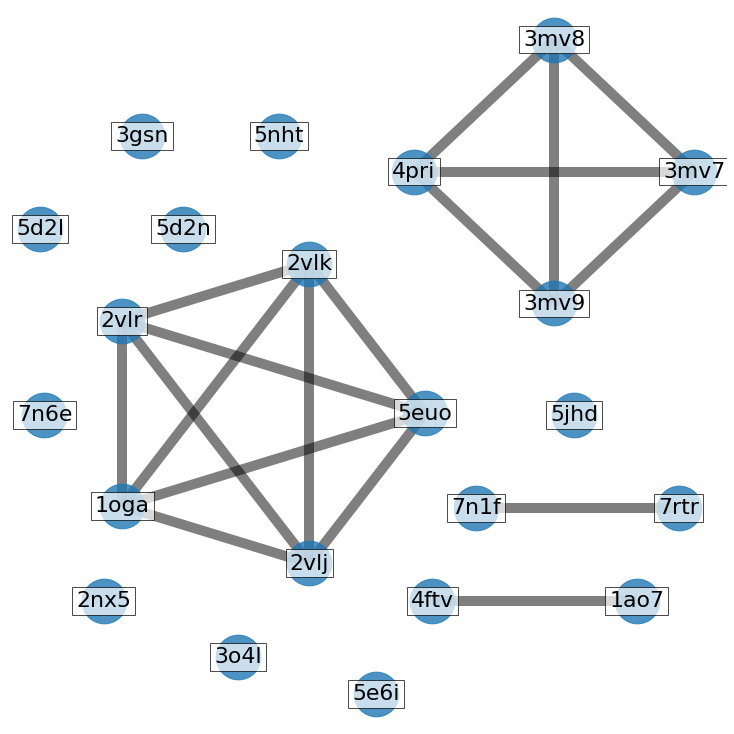

In [11]:
plt.figure(figsize=(10, 10))
pos = nx.nx_pydot.graphviz_layout(G, prog='circo')
nx.nx.draw(G, pos=pos, node_size=2000, width=0, alpha=0.8)
nx.nx.draw_networkx_edges(G, pos=pos, width=10, alpha=0.5)

label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos=pos, font_size=22, bbox=label_options)

plt.show()

### Grouping

In [12]:
def reset_index(df, new_index):
    ind = pd.Index(new_index)
    ind.name = None
    ind.length = None
    df.index = ind

In [13]:
# Grouping
grouping_params = ['chain.type', 'cdr3.to', 'peptide', 'v.segm', 'j.segm', 'resid.cdr3.pose', 'resid.peptide']

print(f'Before grouping: {contacts_filtered.shape[0]} contacts')
grouping_index = contacts_filtered.groupby(grouping_params, as_index=False).first()['_index']
reset_index(contacts_filtered, contacts_filtered['_index'])

contacts_grouped = contacts_filtered.loc[grouping_index]
contacts_grouped['byres.energy'] = contacts_filtered.groupby(grouping_params, as_index=False)['byres.energy'].mean()['byres.energy'].values
contacts_grouped['min.distance'] = contacts_filtered.groupby(grouping_params, as_index=False)['min.distance'].mean()['min.distance'].values
print(f'After grouping : {contacts_grouped.shape[0]} contacts')

Before grouping: 638 contacts
After grouping : 376 contacts


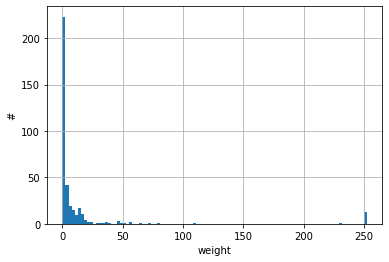

In [14]:
contacts_grouped['weights'] = weights_by_enegy(contacts_grouped['byres.energy'])
contacts_grouped['weights'].hist(bins=100)
plt.xlabel('weight')
plt.ylabel('#')
plt.show()

### Contacts statistics

In [15]:
def calc_stats(contacts, ax=None, logscale=False, weigted=False):
    """
    Calculates number of contacts between various residues
    """
    aa_df = pd.read_csv('aa.csv', sep='\t', header=None)
    aa_map_id = dict(zip(aa_df[3], aa_df[0]))
    
    contacts_count = np.zeros((20,20), dtype=int)
    if weigted:
        for tcr_aa, pept_aa, w in contacts[['resname.tcr', 'resname.peptide', 'weights']].values:
            contacts_count[aa_map_id[tcr_aa], aa_map_id[pept_aa]] += w
    else:
        for tcr_aa, pept_aa in contacts[['resname.tcr', 'resname.peptide']].values:
            contacts_count[aa_map_id[tcr_aa], aa_map_id[pept_aa]] += 1
        
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(6,5))
        
    if not logscale:
        sns.heatmap(contacts_count, ax=ax)
    else:
        sns.heatmap(np.log1p(contacts_count), ax=ax)
        
    ax.set_xticklabels(aa_df[2].values, rotation=90)
    ax.set_yticklabels(aa_df[2].values, rotation=0)
    ax.set_xlabel('Peptide')
    ax.set_ylabel('CDR3')

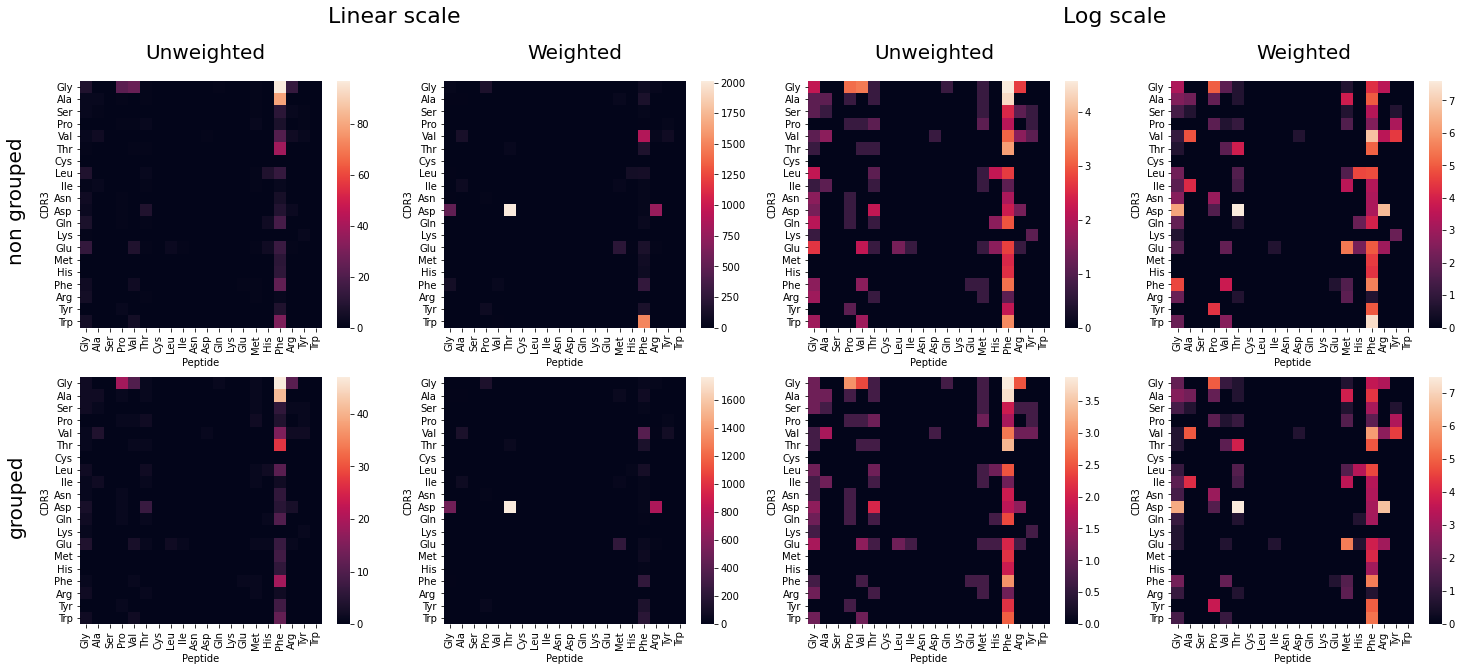

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(25,10))
linear_ax, log_ax = ax[:,:2], ax[:,2:]

is_log = False
calc_stats(contacts_filtered, ax=linear_ax[0,0], logscale=is_log, weigted=False)
calc_stats(contacts_filtered, ax=linear_ax[0,1], logscale=is_log, weigted=True)
calc_stats(contacts_grouped, ax=linear_ax[1,0], logscale=is_log, weigted=False)
calc_stats(contacts_grouped, ax=linear_ax[1,1], logscale=is_log, weigted=True)

is_log = True
calc_stats(contacts_filtered, ax=log_ax[0,0], logscale=is_log, weigted=False)
calc_stats(contacts_filtered, ax=log_ax[0,1], logscale=is_log, weigted=True)
calc_stats(contacts_grouped, ax=log_ax[1,0], logscale=is_log, weigted=False)
calc_stats(contacts_grouped, ax=log_ax[1,1], logscale=is_log, weigted=True)

fig.text(0.3, 0.96, 'Linear scale', ha='center', fontsize=22)
fig.text(0.7, 0.96, 'Log scale', ha='center', fontsize=22)
fig.text(0.195, 0.91, 'Unweighted', ha='center', fontsize=20)
fig.text(0.4, 0.91, 'Weighted', ha='center', fontsize=20)
fig.text(0.6, 0.91, 'Unweighted', ha='center', fontsize=20)
fig.text(0.805, 0.91, 'Weighted', ha='center', fontsize=20)
fig.text(0.09, 0.63, 'non grouped', ha='center', fontsize=20, rotation=90)
fig.text(0.09, 0.25, 'grouped', ha='center', fontsize=20, rotation=90)

plt.show()

# Defining groups by properties

In [17]:
index_nature = pd.read_excel('indices.xlsx', index_col='index_name')
indices = index_nature.index
index_nature = ~index_nature.isna()

for prop in index_nature.columns:
    print('\t', prop)
    print()
    for ind in index_nature.index[index_nature[prop]]:
        print(ind)
    print()

	 Hydrophobicity

Z1
PP2
F1
VHSE1
VHSE2
Blos1
KF4
KF10

	 Steric_properties

atcley.ms
Z2
F3
VHSE3
VHSE4
Blos1
Blos2
Blos3
KF2

	 Electronic_properties

atcley.pah
atcley.ec
Z3
PP1
F6
VHSE5
VHSE6
VHSE7
VHSE8

	 Structure

atcley.pss
F2
Blos1
Blos3
KF1
KF3
KF5
KF8



# PCA analysis

In [18]:
from sklearn.decomposition import PCA

In [19]:
N_COMPONENTS = 10

descriptor_names = np.hstack((cdr3_indices, peptide_indices))
descriptors = contacts_filtered[descriptor_names]
descriptors /= descriptors.std(axis=0)    # normalization of descriptor variance

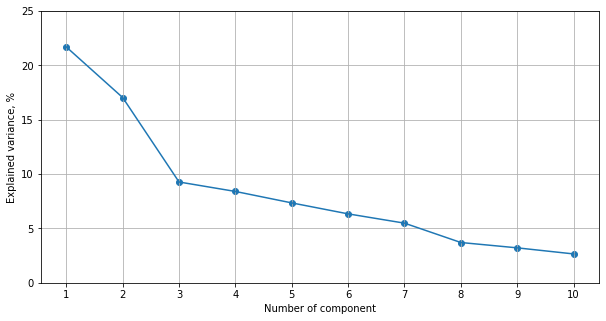

In [20]:
pca = PCA(n_components=N_COMPONENTS)
pca.fit(descriptors)

explained_variance_percent = pca.explained_variance_ratio_ * 100
component_number = np.arange(1, N_COMPONENTS+1)

plt.figure(figsize=(10,5))
plt.plot(component_number, explained_variance_percent)
plt.scatter(component_number, explained_variance_percent)
plt.xticks(component_number)
plt.xlabel('Number of component')
plt.ylabel('Explained variance, %')
plt.ylim(0, 25)
plt.grid()
plt.show()

In [21]:
# Is square root necessary here???

components = pd.DataFrame(pca.components_ * pca.explained_variance_[:,None]**0.5, columns=descriptor_names)    # Considering components length
components_properties = pd.DataFrame(index=components.index, columns=index_nature.columns)

for prop in index_nature.columns:
    prop_columns = descriptor_names[np.hstack((index_nature[prop], index_nature[prop]))]
    prop_df = components[prop_columns]
    components_properties.loc[:,prop] = np.linalg.norm(prop_df, axis=1)
    
# Normalization by the contribution to the overall variation (if needed) 
# components_properties /= components_properties.sum(axis=1).values[:,None]

components_properties

,Hydrophobicity,Steric_properties,Electronic_properties,Structure
0,2.418461,2.360730,1.540760,1.751178
1,1.433404,2.178010,1.673390,1.741531
2,1.188148,1.028761,1.758966,1.069845
3,1.677000,1.267009,1.184442,0.997942
4,1.073367,1.163111,1.379540,0.898704
5,0.364441,0.915929,1.144969,1.030192
6,0.616561,0.963826,0.995106,1.153825
7,0.555599,0.430114,1.175684,0.884266
8,0.368761,0.360807,0.673941,0.961607
9,0.375885,0.288691,0.474327,0.848898


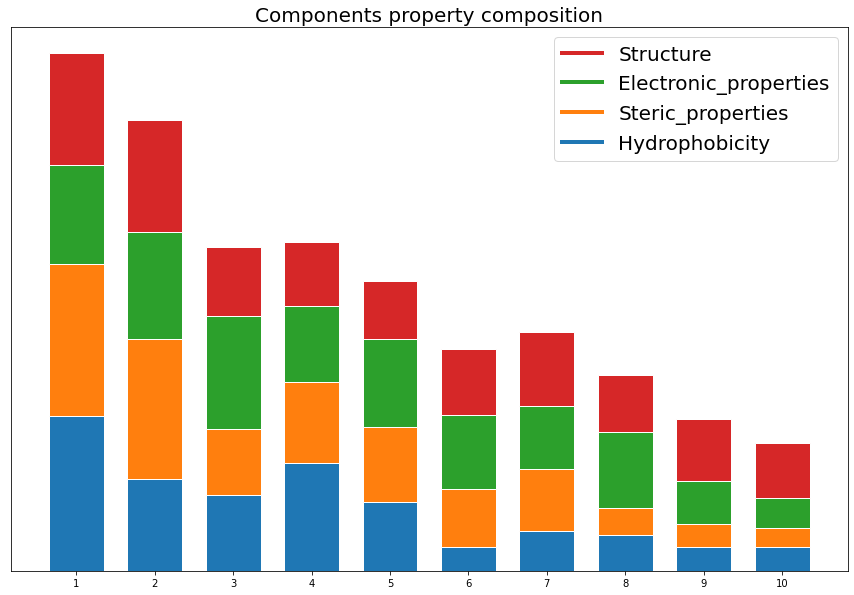

In [22]:
from matplotlib.lines import Line2D

plt.figure(figsize=(15,10))
plt.xticks(component_number)
plt.yticks([])

bottom = np.zeros(N_COMPONENTS)
custom_lines = []
i = 0
for prop in index_nature.columns:
    layer_heigth = components_properties[prop] #* explained_variance_percent
    plt.bar(component_number, layer_heigth, bottom=bottom, edgecolor='white', width=0.7, color=f'C{i}')
    custom_lines.append(Line2D([0], [0], color=f'C{i}', lw=4))
    bottom += layer_heigth
    i += 1
    
plt.legend(custom_lines[::-1], index_nature.columns[::-1], fontsize=20)
plt.title('Components property composition', fontsize=20)
plt.show()

# Correlation analysis

In [23]:
def pairwise_correlation_of_indices(df, cdr3_indices, peptide_indices, method='pearson'):
    return (df[np.hstack((cdr3_indices, peptide_indices))]
            .corr(method=method)
            .loc[cdr3_indices, peptide_indices])

In [24]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr_w(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def pairwise_correlation_of_indices_weighted(df, cdr3_indices, peptide_indices, 
                                             weights='weights'):
    corr_df = pd.DataFrame(index=cdr3_indices, columns=peptide_indices, dtype=np.float32)
    W = df[weights]
    for cdr_ind in cdr3_indices:
        for pep_ind in peptide_indices:
            corr_df.loc[cdr_ind, pep_ind] = corr_w(
                df[cdr_ind],
                df[pep_ind],
                df[weights]
            )
    
    return corr_df

In [25]:
def corr_analysis(contacts_df, index_nature=None, is_weighted=False, text_size=25, figscale=1):
    if index_nature is None:
        index_nature = pd.DataFrame(index=index_names)
        index_nature[''] = True
        figscale = 2
        
        
    corr_count_func = pairwise_correlation_of_indices_weighted if is_weighted else pairwise_correlation_of_indices

    fig, ax = plt.subplots(4, index_nature.columns.size + 1,
                           figsize=np.array((index_nature.columns.size*7 + 0.2, 11.2)) * figscale,
                           gridspec_kw={'width_ratios': [7]*index_nature.columns.size + [0.2],
                                        'height_ratios': [0.1, 7, 4, 0.1]})

    corr_list = []
    max_corr = 0
    print(f'\t\tMAX VALUES\n{"Property":<22}\tCDR3\tPeptide\tR^2')
    print('-'*45)
    for prop in index_nature.columns:
        corr_list.append(corr_count_func(
            contacts_df,
            cdr3_indices[index_nature[prop]],
            peptide_indices[index_nature[prop]],
        ))
        max_corr = max(max_corr, corr_list[-1].abs().max().max())
        ind, max_r2 = get_df_max_index(corr_list[-1]**2)
        ind_cdr = ind[0].split('.')[1]
        ind_pept = ind[1].split('.')[1]
        print(f'{prop:<22}\t{ind_cdr}\t{ind_pept}\t{max_r2:.3f}')
    
    i = 0
    for prop in index_nature.columns:
        corr = corr_list[i]
        # print(f'{prop}:\t{(corr**2).max():.3f}')
        ax_prop = ax[:,i]
        ax_prop[0].text(0.5, 0, 
                        prop,
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=text_size,
                       )
        
        ax_prop[0].set_axis_off()

        corr_values = corr.values.flatten()
        N = corr_values.size

        t_stats = corr_values * np.sqrt((N - 2) / (1 - corr_values**2))
        corr_p_values = 1 - sts.t.cdf(np.abs(t_stats), N-2)


        # print(prop)
        # alpha=0.05
        # print('Sign:', multipletests(corr_p_values, alpha/2)[0].mean())
        # print(corr_values.min(), corr_values.max())
        # print()

        sns.heatmap(corr**2, vmin=0, vmax=max_corr**2, square=True, 
                    ax=ax_prop[1], cbar_ax=ax[1,-1])
        ax_prop[1].set_title("Pearson's R^2" + (" weighted by contact energy" if is_weighted else ""))
        ax_prop[1].tick_params(axis='x', rotation=90)

        sns.histplot(corr.values.flatten(), bins=index_nature[prop].sum(), ax=ax_prop[2])
        ax_prop[2].set_title('Pearson correlation coefficients distribution')

        ax_prop[3].text(0.5, 1, 
                        f'Shapiro-Wilk Test p-value = {shapiro(corr.values.flatten())[1]:.3f}',
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=text_size-5,
                       )
        ax_prop[3].set_axis_off()

        i += 1

    ax[0,-1].set_axis_off()
    ax[2,-1].set_axis_off()
    ax[3,-1].set_axis_off()

    # fig.tight_layout()
    plt.subplots_adjust(left=0.1,
                        bottom=0.02, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.show()
    

In [26]:
contacts = contacts_grouped # contacts_filtered

## Unweighted

		MAX VALUES
Property              	CDR3	Peptide	R^2
---------------------------------------------
                      	F2	VHSE8	0.117


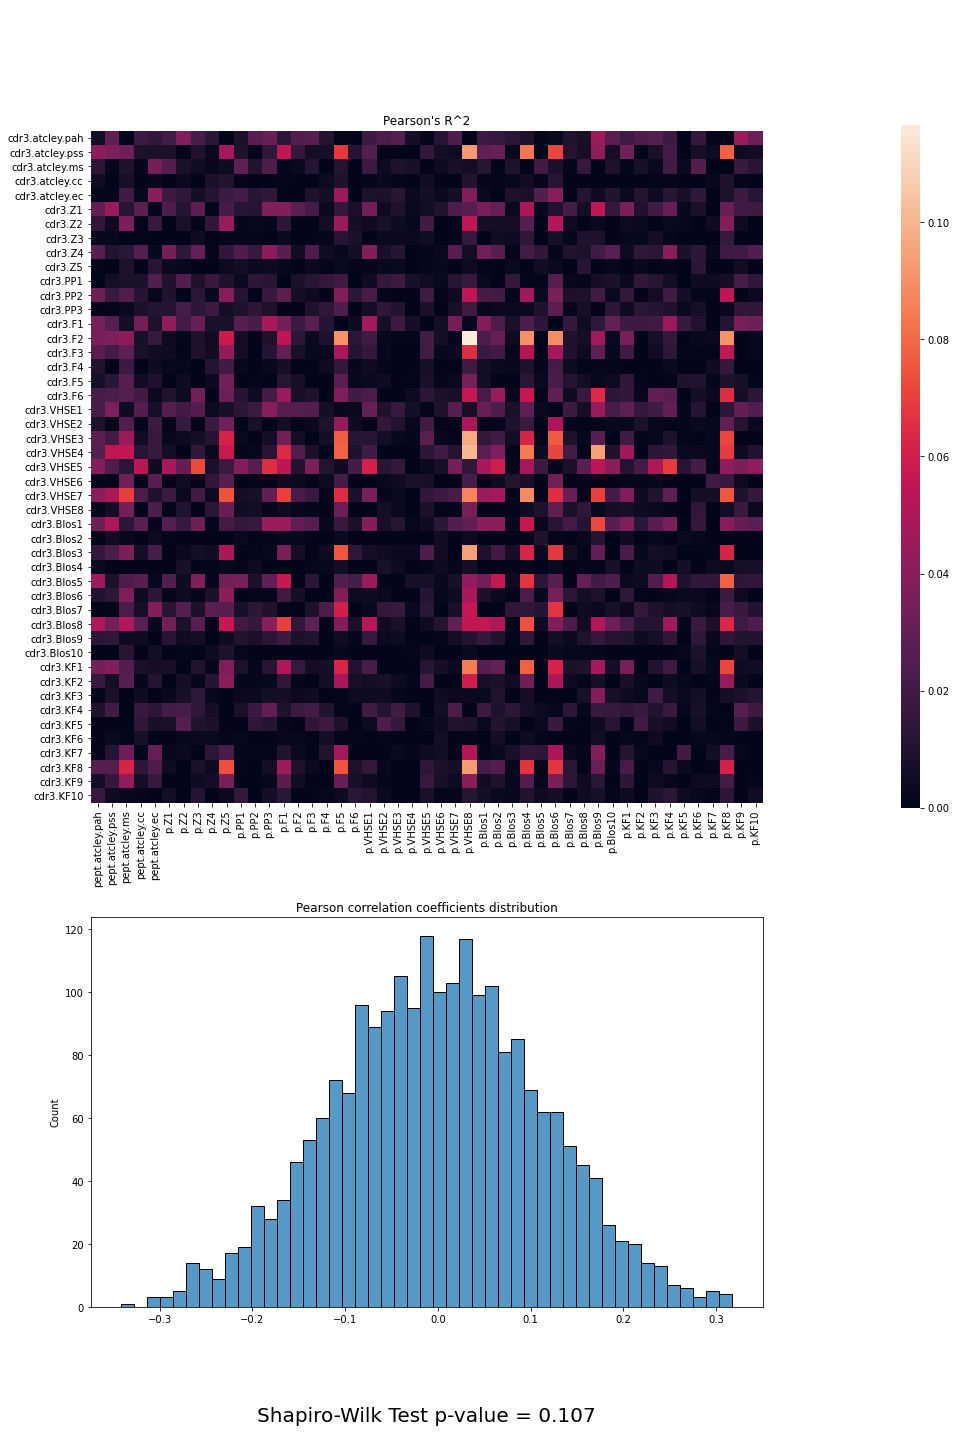

In [27]:
corr_analysis(contacts)

		MAX VALUES
Property              	CDR3	Peptide	R^2
---------------------------------------------
Hydrophobicity        	F1	VHSE1	0.047
Steric_properties     	VHSE4	atcley	0.056
Electronic_properties 	VHSE7	VHSE8	0.087
Structure             	F2	KF8	0.090


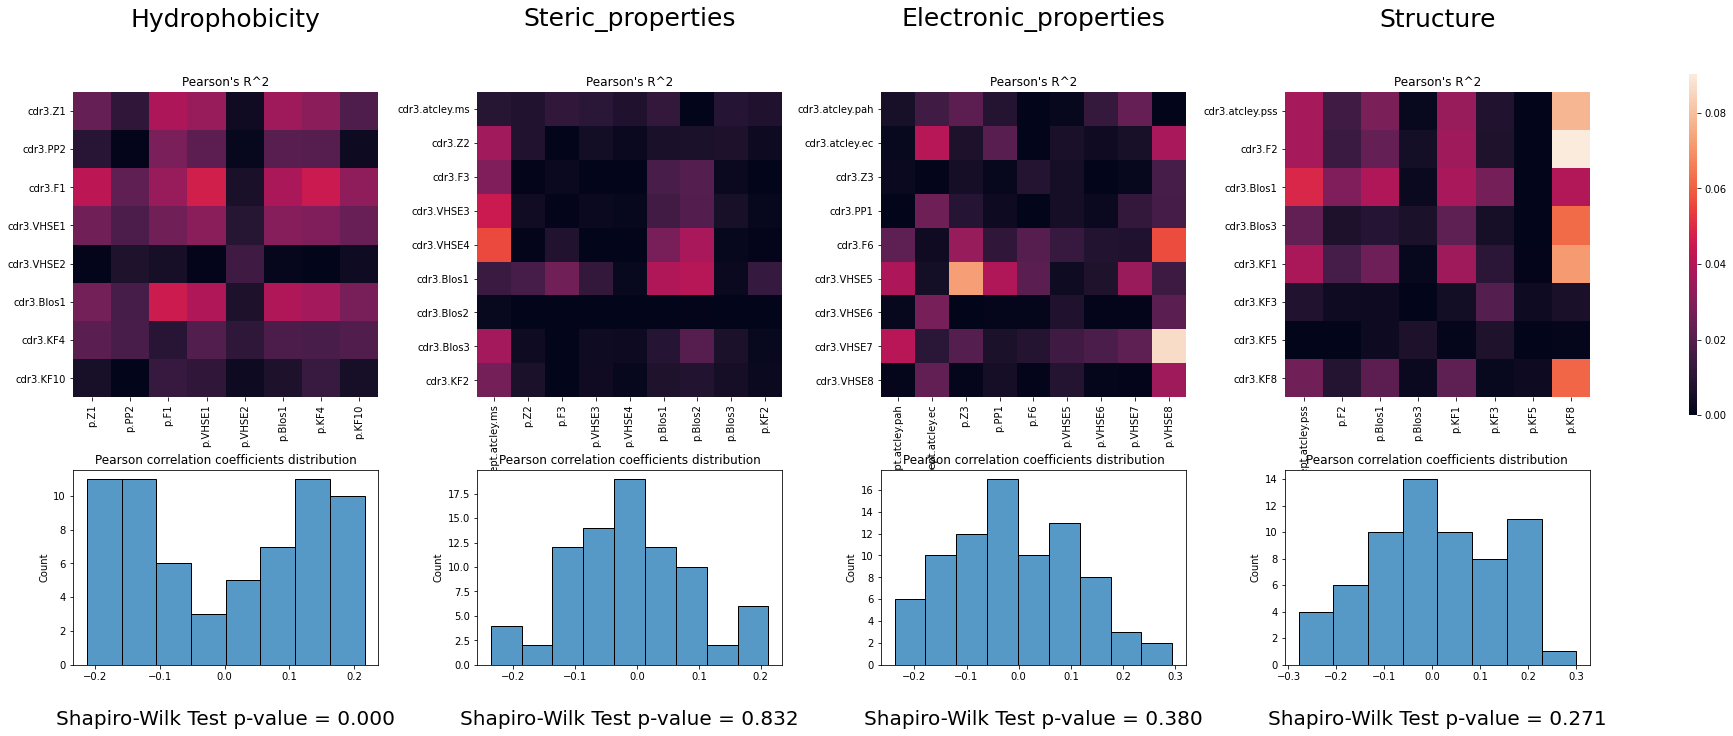

In [28]:
corr_analysis(contacts, index_nature)

## Weighted

		MAX VALUES
Property              	CDR3	Peptide	R^2
---------------------------------------------
                      	VHSE5	PP3	0.591


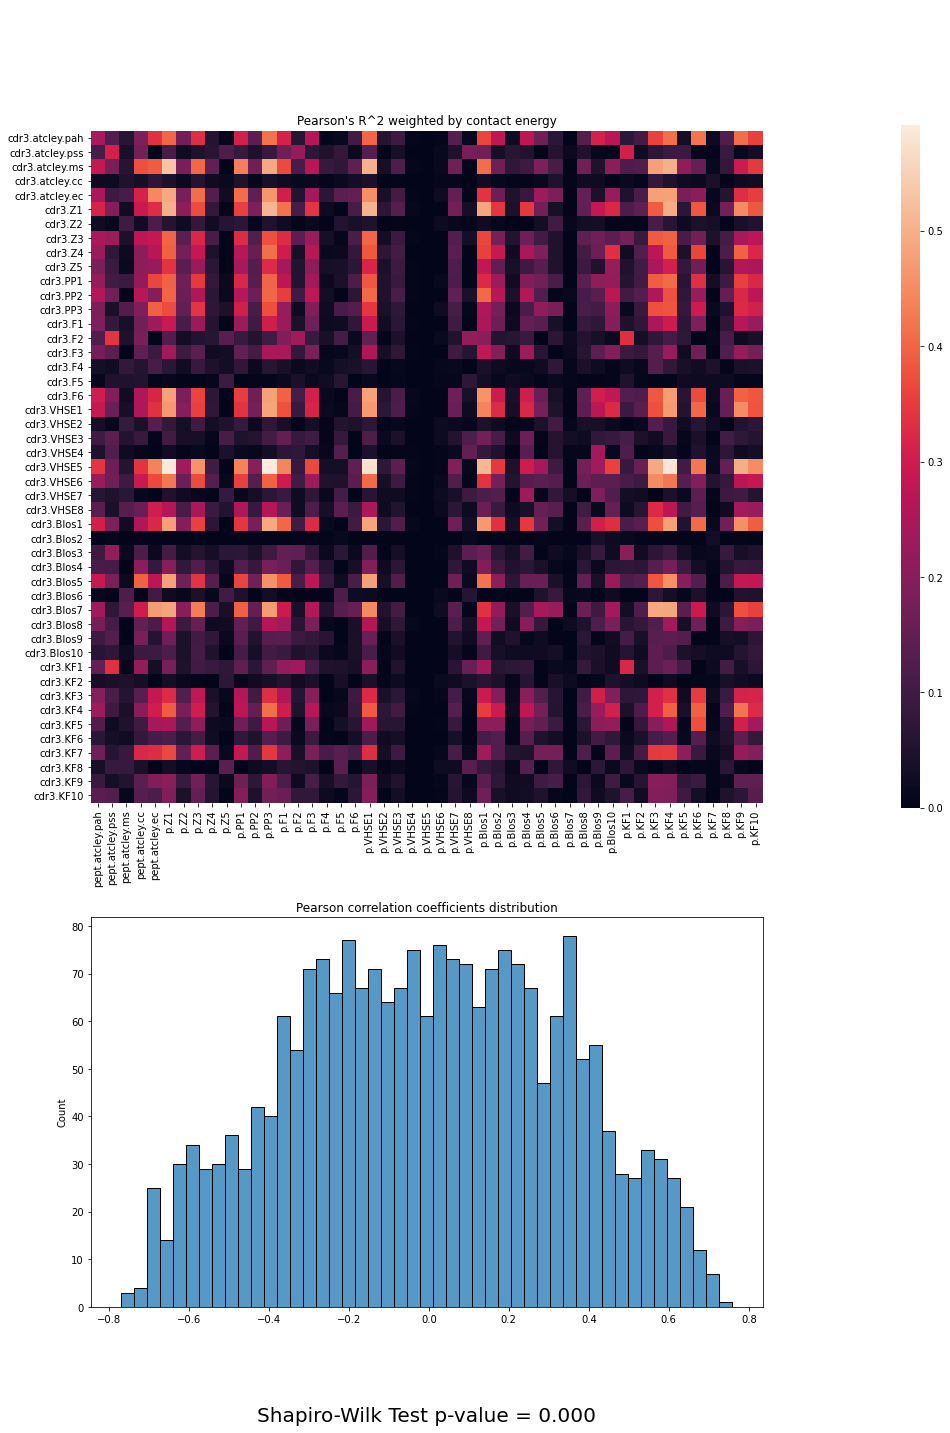

In [29]:
corr_analysis(contacts, is_weighted=True)

		MAX VALUES
Property              	CDR3	Peptide	R^2
---------------------------------------------
Hydrophobicity        	Z1	VHSE1	0.505
Steric_properties     	Blos1	Blos1	0.467
Electronic_properties 	VHSE5	Z3	0.461
Structure             	Blos1	Blos1	0.467


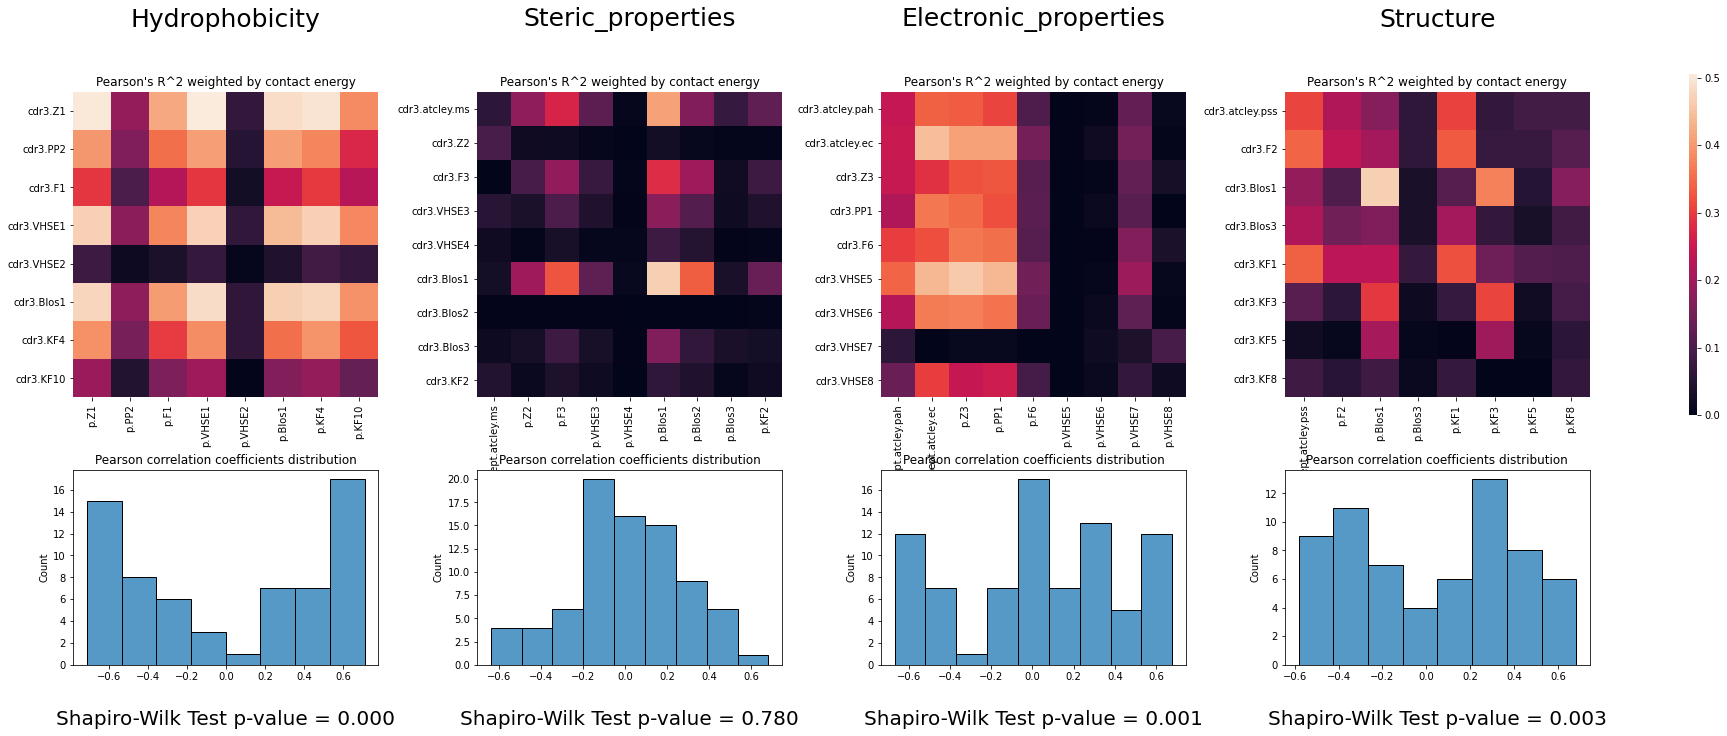

In [30]:
corr_analysis(contacts, index_nature, is_weighted=True)

# Substitutions in important positions

In [31]:
original_structures = pd.read_csv('normal_pdbs_CDR3_contacts_energy_RIN_descriptors.csv')
original_structures = original_structures[
    (original_structures['complex.species'] == 'Human')
    & (original_structures['mhc.type'] == 'MHCI')
    & (original_structures['energy.type'] == ENERGY_TYPE)
]
original_structures['pdb_id'] = [s[:s.find('_')] for s in original_structures['pdb.id']]
original_structures.reset_index(inplace=True)
original_structures.rename(columns={'index': '_index'}, inplace=True)

In [32]:
# Grouping
grouping_params = ['pdb_id', 'chain.type']
filtering_feature = ('byres.energy', 'min.distance')[0]

grouping_index = original_structures.groupby(grouping_params, as_index=False).min(filtering_feature)['_index']
reset_index(original_structures, original_structures['_index'])

best_contacts = original_structures.loc[grouping_index]
# best_contacts.head(2)

In [33]:
mutations = contacts_grouped
# mutations = contacts_filtered

best_contacts['tcr_position'] = best_contacts['resid.tcr']
mutations['tcr_position'] = mutations['resid.mutation']

merged_best_contacts = pd.merge(
     mutations, best_contacts, how='left', on=['pdb_id', 'chain.type', 'tcr_position']
)

collisions = ~merged_best_contacts['_index_y'].isna()
print(f'{collisions.sum()} mutations out of {collisions.size} occurred in the most energetically advantageous positions.')
print(f'It is {collisions.mean()*100:.1f}%')

101 mutations out of 376 occurred in the most energetically advantageous positions.
It is 26.9%


In [34]:
substitutions = merged_best_contacts.loc[collisions, ['resname.tcr_x', 'resname.tcr_y']]

# checking for synonymous substitutions
(substitutions['resname.tcr_x'] == substitutions['resname.tcr_y']).sum()

0

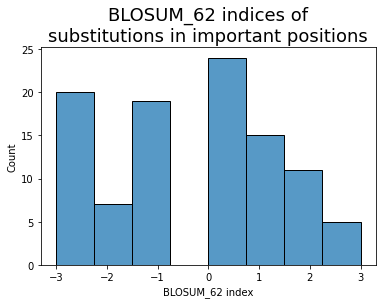

In [35]:
import blosum as bl

blosum_matrix = bl.BLOSUM(62)
sns.histplot([blosum_matrix[sub.sum()] for sub in substitutions.values])
plt.xlabel('BLOSUM_62 index')
plt.title('BLOSUM_62 indices of\nsubstitutions in important positions', fontsize=18)
plt.show()